In this notebook, we will give a summary of our pipeline applied to the detection of ICMEs

In [52]:
# import libs
import pandas as pds
import datetime
import numpy as np
import spacepy.pycdf as pycdf
import scipy.constants as constants
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import time
import sys
import wind
import make_data
import features
import performance as prf
import postProcess
import preProcess
import pyarrow.parquet as pq
import event as evt
import windows as wdw

from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from sklearn.preprocessing import StandardScaler
import numpy.random as random
from lmfit import models
from scipy.signal import find_peaks, peak_widths
from scipy.ndimage import median_filter

## preprocess and model training

In [19]:
# Load data and event list
directory = '../data/datasets/'
data = make_data.loadParquet(directory+'datasetWithSpectro.parquet')

evtList = evt.read_csv('listOfICMEs.csv', index_col=None)

../mainCode/detection/event.py:170: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  df = pds.read_csv(filename, index_col, header)


In [20]:
#pre proces on the data set
features.computeBeta(data)
features.computePdyn(data)
features.computeRmsBob(data)


startTime = datetime.datetime(1997,10,1)
endTime = datetime.datetime(2016,1,1)
data = data[data.index<endTime]
data = data[data.index>startTime]
data = data.resample('10T').mean().dropna()


<IPython.core.display.Javascript object>


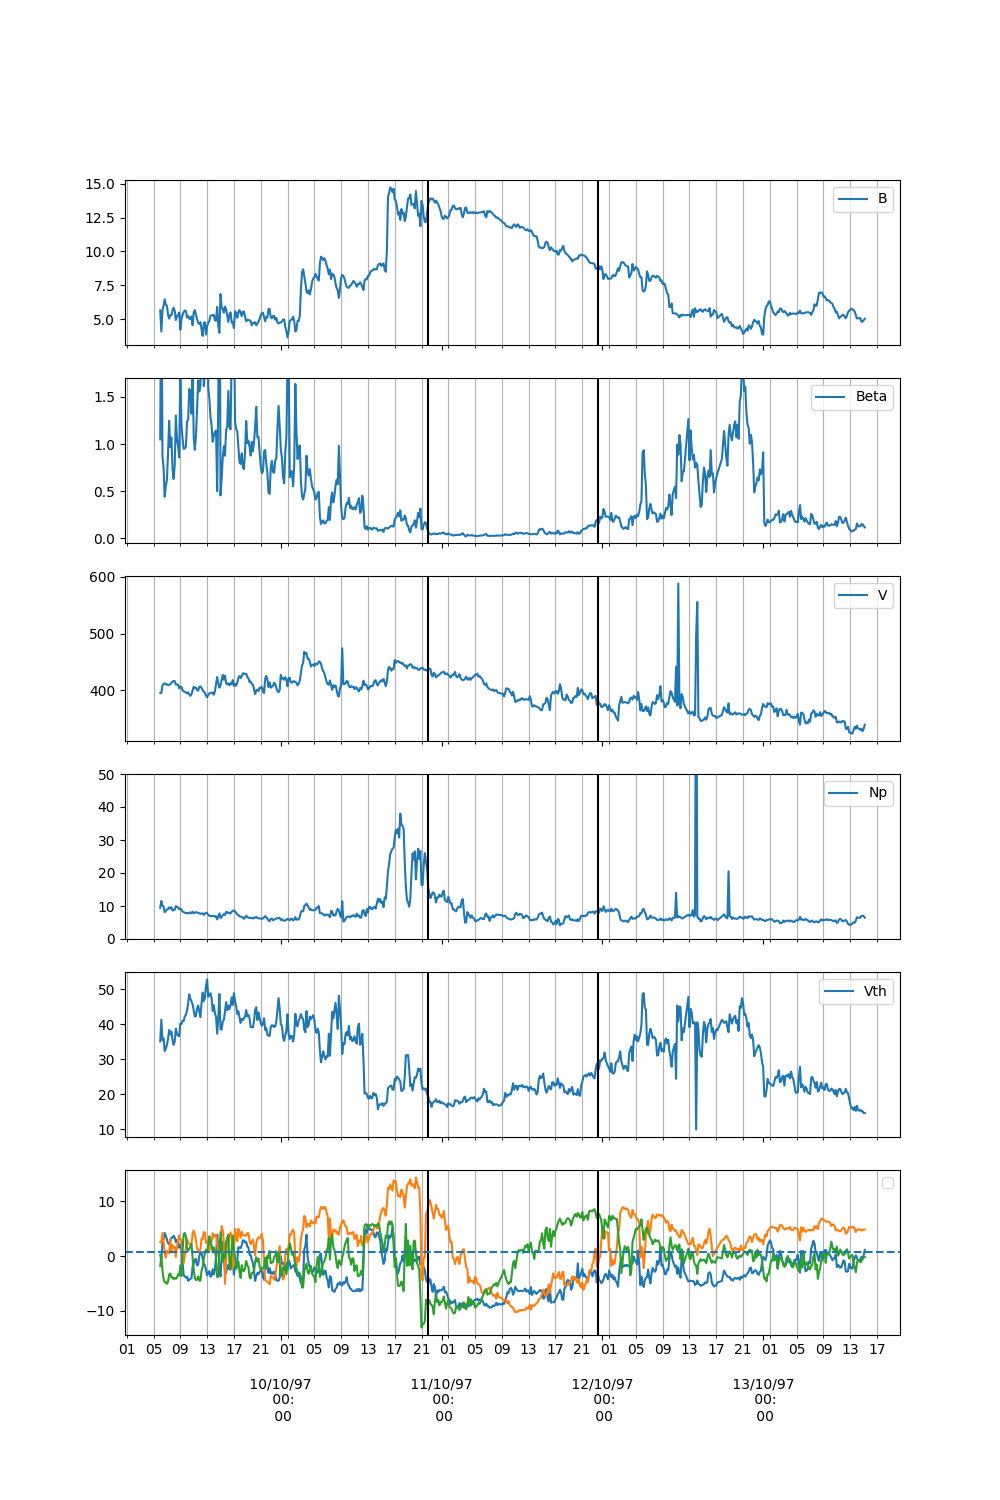

(<Figure size 1000x1500 with 6 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0ca43f9c18>,
       dtype=object))

In [38]:
#Plot a given event

evtList[3].plot(data, figsize=(10,15), delta=40)

In [13]:
# computation of the similarity parameter

results = Parallel(n_jobs=20)(delayed(evt.get_similarity)(data, width, evtList) for width in windows)

similarities = pds.DataFrame(index = data.index)
for width in windows:
    similarities[str(width)] = results[int(width)]

In [39]:
#Well, this task is really long so we will just load these values

similarities = pds.read_csv('../data/similarities.csv', index_col=0)

similarities.index = pds.to_datetime(similarities.index, format="%Y/%m/%d %H:%M")

In [42]:
X_train = data[(data.index<datetime.datetime(2010,1,1)) & (data.index>datetime.datetime(1998,1,1))]
X_val = data[data.index<datetime.datetime(1998,1,1)]
X_test = data[data.index>datetime.datetime(2010,1,1)]

In [45]:
scale = StandardScaler()
scale.fit(X_train)
X_train = scale.transform(X_train)
X_val = scale.transform(X_val)
X_test = scale.transform(X_test)

In [46]:
#callbacks
callbacks = []

# reduce learning-rate when reaching plateau
callbacks.append(
    ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                      patience=5, epsilon=0.001,
                      cooldown=1, verbose=1))

# add early stopping
callbacks.append(
    EarlyStopping(monitor='val_loss', min_delta=0.001,
                  patience=10, verbose=1))

In [47]:
def fit_and_predict(X_train,X_val, X_test, width, y, data):
    window = int(6 * width)
    X_train_windowed = wdw.windowed(X_train, window=window)
    X_test_windowed = wdw.windowed(X_test, window=window)
    X_val_windowed = wdw.windowed(X_val, window=window)

    y_train = y[(data.index < datetime.datetime(2010, 1, 1))
                & (data.index > datetime.datetime(1998, 1, 1))][int(window/2)-1:-int(window/2)]
    y_val = y[data.index < datetime.datetime(1998, 1, 1)][int(window/2)-1:-int(window/2)]
    y_test = y[data.index > datetime.datetime(2010, 1, 1)][int(window/2)-1:-int(window/2)]

    weights = get_weights(y, 10)
    weight_train = weights[(data.index < datetime.datetime(2010, 1, 1))
                & (data.index > datetime.datetime(1998, 1, 1))][int(window/2)-1:-int(window/2)]

    input_shape = (window, data.shape[1])

    model = Sequential()
    model.add(
        Conv1D(
            20,
            kernel_size=3,
            padding='causal',
            activation='relu',
            input_shape=input_shape))
    model.add(
        Conv1D(
            20,
            kernel_size=3,
            padding='causal',
            activation='relu',
            input_shape=input_shape))
    model.add(
        Conv1D(
            20,
            kernel_size=3,
            padding='causal',
            activation='relu',
            input_shape=input_shape))
    model.add(
        Conv1D(
            20,
            kernel_size=3,
            padding='causal',
            activation='relu',
            input_shape=input_shape))
    model.add(MaxPooling1D())
    model.add(
        Conv1D(
            20,
            kernel_size=3,
            padding='causal',
            activation='relu',
            input_shape=input_shape))
    model.add(
        Conv1D(
            20,
            kernel_size=3,
            padding='causal',
            activation='relu',
            input_shape=input_shape))
    model.add(
        Conv1D(
            20,
            kernel_size=3,
            padding='causal',
            activation='relu',
            input_shape=input_shape))
    model.add(
        Conv1D(
            20,
            kernel_size=3,
            padding='causal',
            activation='relu',
            input_shape=input_shape))
    model.add(MaxPooling1D())
    model.add(Flatten())
    model.add(Dropout(0.8))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='logcosh', optimizer='sgd')

    model.fit(
        X_train_windowed,
        y_train,
        epochs=100,
        batch_size=128,
        verbose=1,
        validation_data=(X_val_windowed, y_val),
        callbacks=callbacks,
        sample_weight=weight_train)

    y_pred = model.predict(X_test_windowed, verbose=1)
    y_predSeries = pds.Series(
        index=dataset[dataset.index>datetime.datetime(2010,1,1)].index[int(window/2)-1:-int(window/2)],
        data=np.array([y_pred[i][0] for i in range(0, len(y_pred))]))

    return y_predSeries

In [15]:
# Fit and prediction of the model
windows = np.arange(1, 100,1)

for width in windows:
    prediction = fit_and_predict(X_train, X_val, X_test, width, similarities[str(width)], data)
    prediction.to_csv('../results/similarityRegression/predictions/weighted/pred'+str(width)+'.csv')
    

In [53]:
# prediction loading

prediction = pds.DataFrame(index = data[data.index>datetime.datetime(2010,1,1)].index)

for width in windows :
    prediction[str(width)] = 0
    df = pds.read_csv('../results/similarityRegression/predictions/weighted/pred'+str(width)+'.csv', header=None, index_col=0)
    prediction[str(width)][prediction.index.isin(df.index)] = df.values
    
    
prediction = pds.DataFrame(index = prediction.index, data = median_filter(prediction.values, (1,5)))

/home/nguyen/venv/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/nguyen/venv/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/nguyen/venv/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/nguyen/venv/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of

/home/nguyen/venv/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/nguyen/venv/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/nguyen/venv/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/nguyen/venv/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of

/home/nguyen/venv/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/nguyen/venv/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/nguyen/venv/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/nguyen/venv/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of

/home/nguyen/venv/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/nguyen/venv/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/nguyen/venv/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/nguyen/venv/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of

In [66]:
#From raw prediction to ICME list

integral = prediction.sum(axis=1)
ICMEs = postProcess.turn_peaks_to_clouds(integral, 12)


In [22]:
%matplotlib notebook

In [54]:
test_clouds = [x for x in evtList if x.begin.year>2009]

In [70]:
#Score by event

TP, FN, FP, detected = prf.evaluate(ICMEs, test_clouds, thres=0.01)

## predict from loaded model

In [1]:
def predict(data, width, path):
    window = int(6 * width)
    scale = joblib.load(path+'scaler'+str(width)+'.pkl')
    model = load_model(path+'model'+str(width)+'.h5')
    X_test = scale.transform(data)
    X_test_windowed = wdw.windowed(X_test, window=window)
    y_pred = model.predict(X_test_windowed, verbose=1)
    y_predSeries = pds.Series(index=data.index[int(window/2)-1:-int(window/2)],data=np.array([y_pred[i][0] for i in range(0, len(y_pred))]))
    return y_predSeries

In [2]:
def get_pred_df(data, windows, path):
    pred = pds.DataFrame(index = data.index)
    for width in windows:
        pred[str(width)] = predict(data, width, path)
    return pds.Dataframe(index=pred.index, data = median_filter(pred.values, (1,5)))

In [ ]:
windows = np.arange(1, 101)
prediction = pds.DataFrame(index = data[data.index>datetime.datetime(1997,10,1)].index)

pred = get_pred_df(data['01/01/2010':], windows, '../models/')

## Prediction heatmap


In [4]:
def plot_pred(event, data, pred):
    
    df = data[event.begin:event.end]
    
    fig, axarr = plt.subplots(nrows=7, ncols=1, figsize=(10,15),sharex=True)
    axarr[0].plot(df.index, df['B'], color='gray', linewidth=2.5)
    axarr[0].plot(df.index, df['Bx'])
    axarr[0].plot(df.index, df['By'])
    axarr[0].plot(df.index, df['Bz'])
    axarr[0].legend(['B', 'Bx', 'By', 'Bz (nT)'], fontsize=12,loc='center left', bbox_to_anchor=(1, 0.5))
    axarr[0].set_ylabel('Magnetic Field (nT)', fontsize=30)
    axarr[1].plot(df.index, df['Beta'], color='gray')
    axarr[1].set_ylim(-0.05, 1.7)
    axarr[1].set_ylabel('Beta', fontsize=30)
    axarr[2].plot(df.index, df['V'], color='gray')
    axarr[2].set_ylabel('V(km/s)', fontsize=30)
    axarr[2].set_ylim(250, 700)
    axarr[3].plot(df.index, df['Vth'], color='gray')
    axarr[3].set_ylabel('$V_{th}$(km/s)', fontsize=30)
    axarr[3].set_ylim(5, 60)


    t_data = pred.index
    similarities_tmp = pred.values.T
    xx, yy = np.meshgrid(t_data, np.arange(0, len(pred.columns)))
    im1 = axarr[5].pcolormesh(xx, yy, similarities_tmp, vmin=0, vmax=1, cmap='jet')
    axarr[5].set_ylabel('Window size (hr)', fontsize=30)

    axarr[5].text(1.0, 0.9, 'Prediction', transform=axarr[5].transAxes, fontsize=30, verticalalignment='top', rotation=-90)
    cbar = fig.colorbar(im1, orientation='horizontal')
    cbar.set_label(label='similarity', fontsize=20)
    cbar.ax.tick_params(labelsize=20)


    for ax in axarr:
        #ax.xaxis.set_minor_locator(mdates.HourLocator(interval=24))
        ax.xaxis.set_minor_formatter(mdates.DateFormatter('%d/%m/%y'))
        #ax.xaxis.set_major_locator(mdates.DayLocator(interval=0.5))
        #ax.xaxis.set_major_formatter(mdates.DateFormatter('\n\n %d/%m/%y'))
        ax.xaxis.grid(True, which="minor")
        ax.xaxis.set_tick_params(labelsize=15)
        ax.yaxis.set_tick_params(labelsize=15)




In [ ]:
start = datetime..datetime(2010,1,1)
end = datetime..datetime(2010,6,1)


event = evt.Event(start, end)

plot_pred(event, data, pred)